In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from tqdm import tqdm
from cv2 import cv2

In [4]:
numx = 30
numy = 60
x0 = numx // 2
y0 = numy // 2
t0 = 0

## Green's function (before optimizing)

$G(\rho, t) = \Theta (t - \frac{\rho}{v}) (1 - e^{-\frac{t-\rho/v}{\tau_\text{inc}}}) e^{-\frac{t-\rho/v}{\tau_\text{dec}}} e^{-\frac{\rho}{\rho_c}}$

In [5]:
def greens_function_fast(x, y, t, x0, y0, t0, tau_inc=0.02, tau_dec=1, rho_e=150, v=500):
    
    t = t - t0
    c_x = 1
    c_y = 1
    rho = np.sqrt(c_x * (x - x0) ** 2 + c_y * (y - y0) ** 2)
    if t <= rho / v:
        return 0.05
    else:
        return (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e) + 0.05

In [6]:
dt = 0.01
dx = 1
dy = 1

trange = np.arange(0, 2, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_fast(x, y, t, x0, y0, t0)

200it [00:02, 72.90it/s]


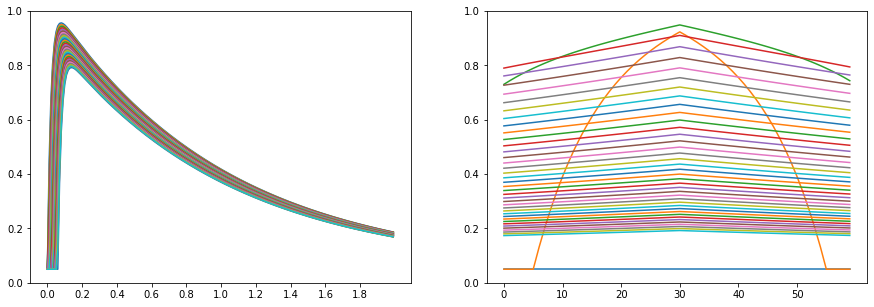

In [7]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(data_mat[:, data_mat.shape[1] // 2, ::])
ax1.set_ylim(0, 1)
ax1.set_xticks(range(0, len(trange), 20))
ax1.set_xticklabels([round(t, 2) for t in trange[::20]])

ax2 = fig.add_subplot(122)
ax2.plot(data_mat[::5, data_mat.shape[1] // 2, ::1].T)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(0, len(yrange), 10))
ax2.set_xticklabels([int(y) for y in yrange[::10]])
plt.show()

## Biophysical model

In [8]:
from hydramuscle.model.smc import SMC
from hydramuscle.model.layer import Layer

In [9]:
# Construct muscle sheet
T = 2
dt = 0.0002
save_interval=5

smc = SMC(T=T, dt=dt, k_ipr=0.2, s0=100, k_deg=0.01)
layer = Layer(smc, 
              numx=numx, 
              numy=numy, 
              gip3x=0.1, 
              gip3y=2.0, 
              gcx=1000, 
              gcy=1000,
              save_interval=save_interval)

layer.set_stim_pattern(pathway='fast',
                       xmin=14, xmax=16, ymin=29, ymax=31,
                       stim_times=[0])

sol = layer.run(save_all=True)

100%|██████████| 10000/10000 [00:03<00:00, 2820.21it/s]


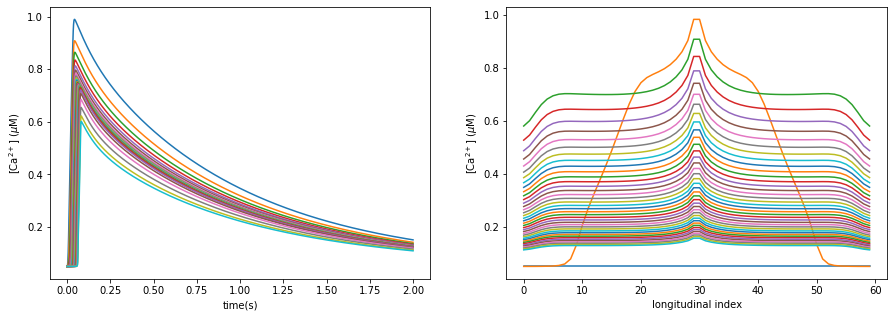

In [10]:
calcium = sol[:, :numx * numy].reshape(-1, numx, numy)
calcium_lon = calcium[:, numx // 2, :]

# Plot
fig = plt.figure(figsize=(15,5))
# Calcium waves
ax11 = fig.add_subplot(121)
ax11.plot(np.arange(0, T, dt*save_interval), calcium_lon[:, numy // 2:])
ax11.set_xlabel('time(s)')
ax11.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
# Calcium wavefronts
ax12 = fig.add_subplot(122)
ax12.plot(calcium_lon[::50].T)
ax12.set_xlabel('longitudinal index')
ax12.set_ylabel(r'[Ca$^{2+}$] ($\mu$M)')
plt.show()

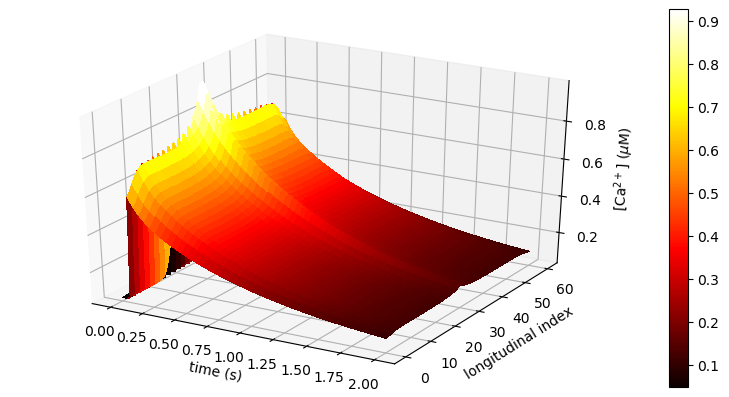

In [11]:
# Plot surface
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.axes(projection='3d')
X = np.outer(np.linspace(0, 2, 2000), np.ones(60))
Y = np.outer(np.ones(2000), np.linspace(0, 60, 60))
surf = ax.plot_surface(X, Y, calcium_lon, cmap='hot', antialiased=False)
ax.set_xlabel('time (s)')
ax.set_ylabel('longitudinal index')
ax.set_zlabel('[Ca$^{2+}$] ($\mu$M)')
fig.colorbar(surf)
plt.savefig('../../results/figures/lon_trace_biophy_fast.pdf', bbox_inches='tight')
plt.show()

## Option 1: Fitting certain parameters

### 1. Fit $\tau_\text{inc}$ and $\tau_\text{dec}$ with the first trace

In [12]:
first_trace = calcium_lon[:, numy // 2]

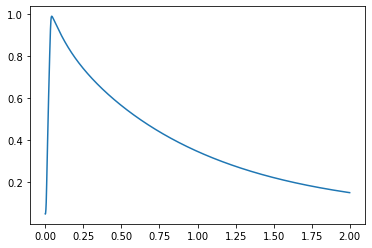

In [13]:
# Have a look ...
plt.figure()
t_seq = np.arange(0, T, dt*save_interval)
plt.plot(t_seq, first_trace)
plt.show()

In [15]:
# Extract the time scales of increasing and decreasing phases

def calc_time_scales(arr, dt):

    ind_max = np.argmax(arr)
    time_inc = ind_max * dt
    time_dec = np.inf

    for index, v in enumerate(arr):
        if index > ind_max and v < 0.2:
            time_dec = (index - ind_max) * dt
            break
            
    return time_inc, time_dec

time_inc, time_dec = calc_time_scales(first_trace, dt=dt * save_interval)

print('increasing time is ', round(time_inc, 4))
print('decreasing time is ', round(time_dec, 4))
print('amplitude is', round(max(first_trace), 4))

increasing time is  0.042
decreasing time is  1.588
amplitude is 0.9898


In [16]:
# Formulate the Green's function of the origin point
def gf_origin(tau_inc, tau_dec, amp, t):
    return amp * (1 - np.exp(- t / tau_inc)) * np.exp(- t / tau_dec) 

In [17]:
# Sweep the parameters to fit the time scales
def loss(t_inc, t_dec, time_inc, time_dec):
    return (t_inc - time_inc) ** 2 + (t_dec - time_dec) ** 2

tau_inc_best = None
tau_dec_best = None
t_inc_best = None
t_dec_best = None
loss_best = np.inf

for tau_inc in tqdm(np.arange(0.001, 0.02, 0.001)):
    for tau_dec in np.arange(0.01, 2, 0.01):
        sim_trace = []
        for t in np.arange(0, 2, 0.001):
            sim_trace.append(gf_origin(tau_inc, tau_dec, 1, t))
        t_inc, t_dec = calc_time_scales(sim_trace, 0.001)
        loss_tmp = loss(t_inc, t_dec, time_inc, time_dec)
    
        if loss_tmp < loss_best:
            loss_best = loss_tmp
            tau_inc_best, tau_dec_best = tau_inc, tau_dec
            t_inc_best, t_dec_best = t_inc, t_dec

100%|██████████| 19/19 [00:22<00:00,  1.16s/it]


In [18]:
# Calculate the best amp
sim_trace = []
for t in np.arange(0, 2, 0.001):
    sim_trace.append(gf_origin(tau_inc_best, tau_dec_best, 1, t))

amp_best = max(first_trace - 0.05) / max(sim_trace) 
sim_trace = [x*amp_best + 0.05 for x in sim_trace]

In [19]:
# Print the fitting result
print(tau_inc_best, tau_dec_best, amp_best)

0.008 1.01 0.9843129170437892


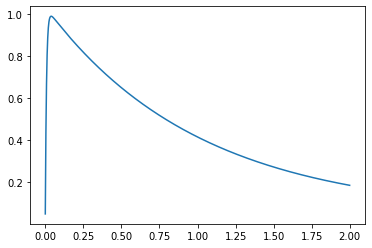

In [20]:
# Plot the simulated curve
plt.figure()
plt.plot(np.arange(0, 2, 0.001), sim_trace)
plt.show()

### 2. Fit $v$, $\rho_e$

In [21]:
# Measure the time lag and amplitude difference between the first and last trace
last_trace = calcium[:, numx // 2, numy - 1]
# last_trace_x = calcium[:, numx - 1, numy // 2]

def calc_diffs(last_trace, first_trace, dt):
    t_lag = np.argmax(last_trace) * dt - np.argmax(first_trace) * dt
    a_diff = max(first_trace) - max(last_trace)
    return t_lag, a_diff

time_lag, amp_diff = calc_diffs(last_trace, first_trace, dt*save_interval)
# time_lag_x, amp_diff_x = calc_diffs(last_trace_x, first_trace, dt*save_interval)

In [22]:
# Formulate the Green's function for the muscle sheet
def greens_function_2d(x, y, t, x0, y0, t0, tau_inc, tau_dec, amp, v, rho_e):
    
    t = t - t0
    rho = np.sqrt((x - x0) ** 2 + (y - y0) ** 2)
    if t <= rho / v:
        return 0.05
    else:
        return amp * (1 - np.exp(-(t - rho / v) / tau_inc)) * np.exp(-(t - rho / v) / tau_dec) * np.exp(-rho / rho_e) + 0.05

In [23]:
# Sweep the parameters to fit
def loss2(t_lag, time_lag, a_diff, amp_diff):
    return (t_lag / time_lag - 1) ** 2 + (a_diff / amp_diff - 1) ** 2

v_best = None
rho_e_best = None
t_lag_best = None
a_diff_best = None
# t_lag_x_best = None
# a_diff_x_best = None
# c_x_best = None
loss2_best = np.inf

for v in tqdm(range(1, 1100, 10)):
    for rho_e in range(5, 200, 5):
#         for c_x in range(1, 20):
            sim_last_trace = []
#             sim_last_trace_x = []
            for t in np.arange(0, 2, 0.001):
                sim_last_trace.append(greens_function_2d(numx//2, numy-dy, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e))
#                 sim_last_trace_x.append(greens_function_2d(numx-dx, numy//2, t, numx//2, numy//2, 0, tau_inc_best, tau_dec_best, amp_best, v, rho_e))
            t_lag, a_diff = calc_diffs(sim_last_trace, sim_trace, 0.001)
#             t_lag_x, a_diff_x = calc_diffs(sim_last_trace_x, sim_trace, 0.001)
            loss2_tmp = loss2(t_lag, time_lag, a_diff, amp_diff) # + loss2(t_lag_x, time_lag_x, a_diff_x, amp_diff_x)

            if loss2_tmp < loss2_best:
                loss2_best = loss2_tmp
                rho_e_best, v_best = rho_e, v
                t_lag_best, a_diff_best = t_lag, a_diff
#                 t_lag_x_best, a_diff_x_best = t_lag_x, a_diff_x

100%|██████████| 110/110 [00:54<00:00,  2.03it/s]


In [24]:
# Print the best parameter values
rho_e_best, v_best

(55, 731)

In [25]:
t_lag_best, a_diff_best

(0.039, 0.3851227979325671)

In [26]:
time_lag, amp_diff

(0.039, 0.3879329412130966)

In [27]:
# Plot the final simulation results
dt = 0.01
dx = 1
dy = 1

trange = np.arange(0, 2, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_2d(x, y, t, x0, y0, t0, tau_inc_best, tau_dec_best, amp_best, v_best, rho_e_best)

200it [00:02, 73.32it/s]


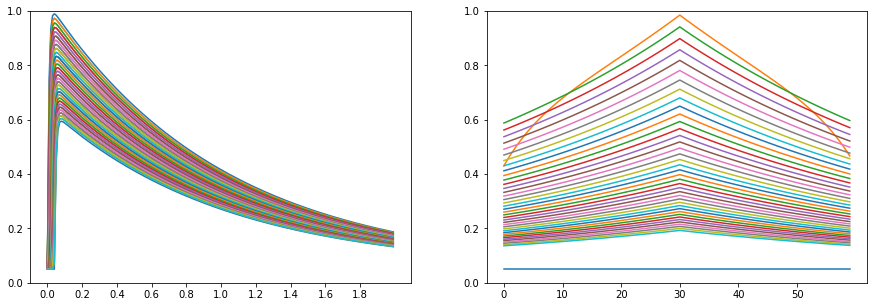

In [28]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(data_mat[:, data_mat.shape[1] // 2, ::])
ax1.set_ylim(0, 1)
ax1.set_xticks(range(0, len(trange), 20))
ax1.set_xticklabels([round(x, 2) for x in trange[::20]])

ax2 = fig.add_subplot(122)
ax2.plot(data_mat[::5, data_mat.shape[1] // 2, ::1].T)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(0, len(yrange), 10))
ax2.set_xticklabels([int(y) for y in yrange[::10]])
plt.show()

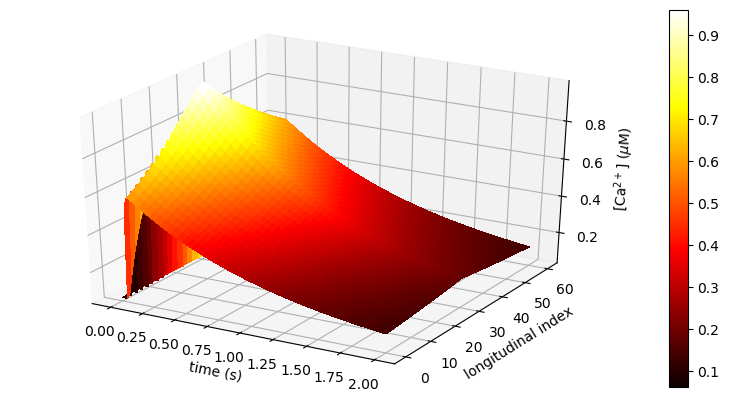

In [29]:
# Plot surface
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.axes(projection='3d')
X = np.outer(np.linspace(0, 2, 200), np.ones(60))
Y = np.outer(np.ones(200), np.linspace(0, 60, 60))
surf = ax.plot_surface(X, Y, data_mat[:, numx//2, :], cmap='hot', antialiased=False)
ax.set_xlabel('time (s)')
ax.set_ylabel('longitudinal index')
ax.set_zlabel('[Ca$^{2+}$] ($\mu$M)')
fig.colorbar(surf)
plt.savefig('../../results/figures/lon_trace_gf_fast.pdf', bbox_inches='tight')
plt.show()

In [30]:
# Save video

numx = 30
numy = 60
dpi = 100
dt = 0.01
data = calcium[::10, :, :]  

fig = plt.figure()
for iframe in range(len(data)):

    plt.clf()
    plt.imshow(np.flip(data[iframe].T, 0),
               vmin=0,
               vmax=1,
               cmap='hot')
    plt.text(1, 5, str(iframe * dt) + 's', color='white', size=15, fontweight='bold')
    plt.colorbar()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig('../../results/videos/frames/img' + str(iframe) + '.jpg', dpi=dpi, bbox_inches='tight')
    plt.close()

In [31]:
# Make video

fps = 50
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
ny, nx, _ = cv2.imread('../../results/videos/frames/img0.jpg').shape
videoWriter = cv2.VideoWriter('../../results/videos/greens_function/2d_ca_fast_biomodel.avi', fourcc, fps, (nx, ny))

for iframe in range(len(data)):
    frame = cv2.imread('../../results/videos/frames/img' + str(iframe) + '.jpg')
    videoWriter.write(frame)
videoWriter.release()
cv2.destroyAllWindows()